In [70]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt

class Param: pass

PRFX_ESMB = 'MelEsmb0727A1'
p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

In [50]:
prfx2wgt = {
    'Mel0726B1': 1,
    'Mel0726C1': 1,
    'Mel0726D1': 1,
    'Mel0726E1': 1,    
}

In [51]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof[:,-param.LASTM:].mean(1)
        oofs += list(oof)
    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)
    print(prfx, roc_auc(ys, oofs))
    prfx2oofs[prfx] = np.array(oofs)

Mel0726B1 0.9186255105750334
Mel0726C1 0.9177213436164805
Mel0726D1 0.9174568068656095
Mel0726E1 0.9166938708137505


In [52]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    oofs_esmb += wgt*prfx2oofs[prfx]
print(prfx, roc_auc(ys, oofs_esmb))

Mel0726E1 0.9306967508268622


Mel0726B1 0.1709435848382643


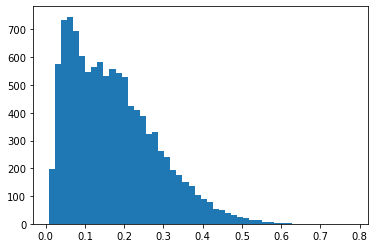

Mel0726C1 0.15498520338773913


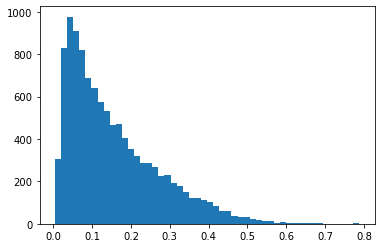

Mel0726D1 0.18698534794493166


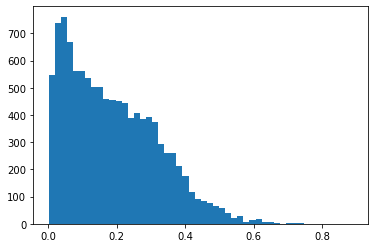

Mel0726E1 0.1666454077276706


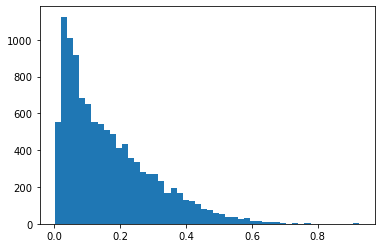

In [68]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 


wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = dfsubi.target
    print(prfx, subi.mean())
    plt.hist(subi, bins=50);
    plt.show()
    sub_esmb+=subi
sub_esmb/=wgt_ttl

0.16988988597465166


,image_name,target
0,ISIC_0052060,0.064934
1,ISIC_0052349,0.032370
2,ISIC_0058510,0.100326


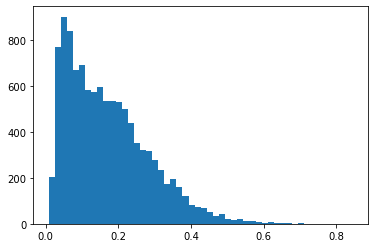

In [66]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [71]:
dfsub.to_csv(f'{p_esmb}/submission_{PRFX_ESMB}.csv', index=False)